In [1]:
import pennylane as qml
from pennylane import numpy as np
import pandas as pd
import jax
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from utils import *
from sklearn.metrics import mean_absolute_error as mse
from sklearn.metrics import r2_score
from pennylane.optimize import AdamOptimizer,QNSPSAOptimizer
from scipy.optimize import minimize
from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")
from autoencoder import Autoencoder



# Use the class


In [2]:
from autoencoder import Autoencoder

epochs= 10
n= 111
opt=AdamOptimizer(stepsize=.2)
X=np.random.rand(n)
np.random.shuffle(X)
n_trash_qubit=1
n_qubit_autoencoder=2
n_qubit=n_qubit_autoencoder+n_trash_qubit+1 

ae = Autoencoder('fd',n_qubit_autoencoder,n_trash_qubit,qml.device('default.qubit', wires=n_qubit, shots=None))
history = ae.train(X,opt,epochs)


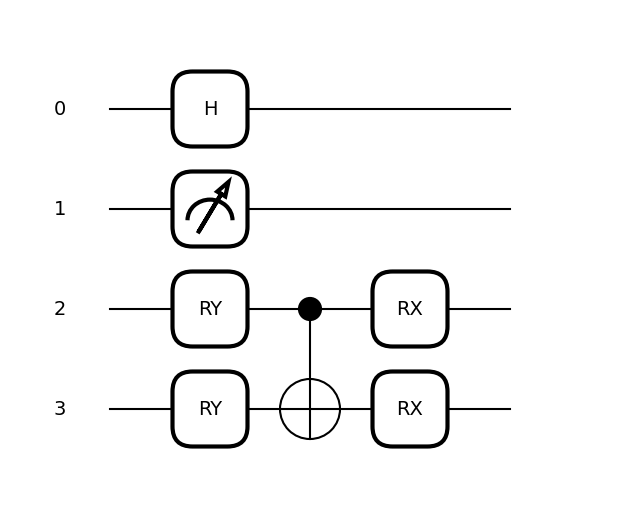

In [5]:
@qml.qnode(qml.device('default.qubit', wires=n_qubit, shots=None))
def pio():
    qml.Hadamard([0])
    qml.Barrier
    ae.get_cirq(2)
    return qml.measure([1])

fig, ax = qml.draw_mpl(pio)()
plt.show()
